## This is a sample Machine Learning project that exemplifies how to proceed Linear Regression Analysis, using Python, Pandas, NumPy, SciPy, Statsmodels, Statstests, Pingouin, Scikit-learn, Matplotlib, Seaborn and Plotly, along with Anaconda managed environments

In [1]:
# pip install --upgrade statstests # gotta install statstests through pip - not available at conda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("dark_background")
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
from scipy.stats import boxcox
from scipy.stats import norm
from scipy import stats
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statstests.process import stepwise
from statstests.tests import shapiro_francia
import pingouin as pg
import seaborn as sns
import plotly.graph_objects as go
import os
import plotly.io as pio
if os.getenv("GITHUB_ACTIONS") == "true":
    pio.renderers.default = "png"
else:
    pio.renderers.default='colab'
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

- the formulas shown at this notebook have been taken from the following reference:

    FÁVERO, L. P.; BELFIORE, P. Manual de Análise de Dados: Estatística e Machine Learning com Excel®, SPSS®, Stata®, R® e Python®. 2ª edição, 1288 p. Brasil: ccGEN LTC, 2024.
    
    Available in Brazil at:
    
    https://www.amazon.com.br/Manual-An-C3-A1lise-Dados-Estat-C3-ADstica-Learning-dp-8595159920/dp/8595159920

## Use Case Scenario and Data - Travel Time = f(Distance). Simple Linear Regression.

This is the simplest use-case for Generalized Linear Models (GLMs) of type Simple Linear Regression (SLR). Here, we have a dataset that basically has the time as a function of the distance for a person to reach a certain place (e.g. a school or university). The only variable X (explicative variable) is the distance to travel, and the Y (dependent variable) is the time to reach the destination. We have thus the actual Y time (given at our dataset), as well as the estimated, predicted or expected Ŷ (Y hat) time (which composes the trend line). We show how to calculate the OLS (Ordinary Least Squares) linear model (function) of the trend line - finding its coefficients (linear and angular) and residuals (Y-Ŷ), as well as the R2 (coefficient of determination), that basically is the sq of the pearson correlation between the actual Y and X values. This R2 coefficient represents how well our model predicts Y based on X, i.e., what percent of Y variance is explained by X, considered the errors (between Y and Ŷ).

In [2]:
# reading and displaying our dataset
# time is in minutes, distance is in Kilometers
time_distance_df = pd.read_csv('time-distance.csv', delimiter=',')
time_distance_df

,time,distance
0,15,8
1,20,6
2,20,15
3,40,20
4,50,25
5,25,11
6,10,5
7,55,32
8,35,28
9,30,20


In [3]:
time_distance_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   time      10 non-null     int64
 1   distance  10 non-null     int64
dtypes: int64(2)
memory usage: 292.0 bytes


In [4]:
time_distance_df.describe()

,time,distance
count,10.00000,10.000000
mean,30.00000,17.000000
std,14.90712,9.510228
min,10.00000,5.000000
25%,20.00000,8.750000
50%,27.50000,17.500000
75%,38.75000,23.750000
max,55.00000,32.000000


Simple Linear Regression formula. Yi observed values function contains the error (deviation) ui variable, while the Ŷi expected (fitted) values function does not contain the error variable - the rest of the function expression is the same. The line is actually the expected (fitted) values, while the Y observed values are the dispersed, scattered, cloud of actual values that deviate from that theoretical line. The closer the dispersed actual values are from the theoretical fitted-value line, the better the predictivity of that regression model (therefore, the higher the R2). The optimal regression model would be the one with R2 equal 1 and all actual observed values exactly at the line, that is, exactly equal to the expected, fitted, values. See below.

![./simple_linear_regression.png](simple_linear_regression.png)

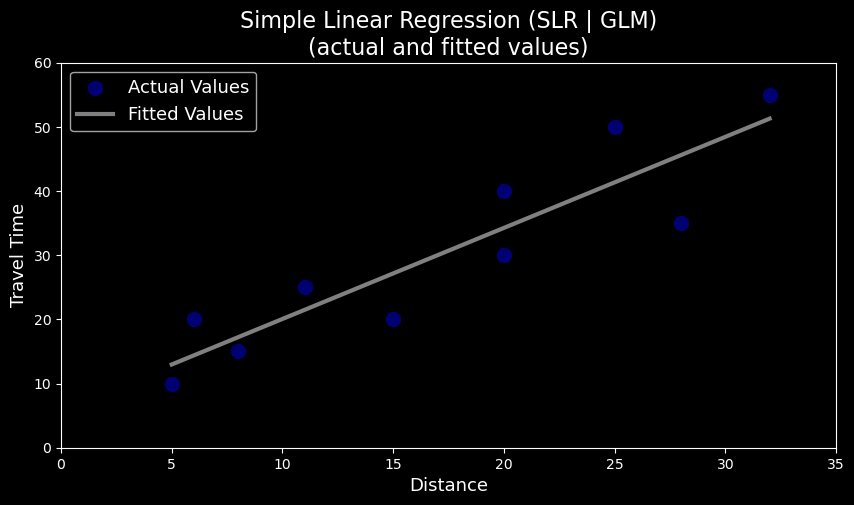

In [5]:
# Plotting scatter graph for SLR (GLM) of our dataset, with actual values (observed data) and fitted values (expected data)
plt.figure(figsize=(10,5))
sns.regplot(data=time_distance_df, x='distance', y='time', marker='o', ci=False,
            scatter_kws={"color":'navy', 'alpha':0.9, 's':100},
            line_kws={"color":'grey', 'linewidth': 3})
plt.title('Simple Linear Regression (SLR | GLM)\n(actual and fitted values)', fontsize=16)
plt.xlabel('Distance', fontsize=13)
plt.ylabel('Travel Time', fontsize=13)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0, 35)
plt.ylim(0, 60)
plt.legend(['Actual Values', 'Fitted Values'], fontsize=13, loc='upper left')
plt.show()

In [6]:
# Plotting INTERACTIVE scatter graph for SLR (GLM) of our dataset, with actual and fitted values
x = time_distance_df['distance']
y = time_distance_df['time']

slope, intercept = np.polyfit(x, y, 1)
y_trend = slope * x + intercept

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(color='navy', size=20), name='Actual Values')
    )

fig.add_trace(go.Scatter(
    x=x,
    y=y_trend,
    mode='lines',
    line=dict(color='dimgray', width=5), name='Fitted Values')
    )

fig.update_traces(
    marker=dict(size=14)
)

fig.update_layout(
    width=850,
    height=500,
    xaxis_title='Distance',
    yaxis_title='Travel Time',
    title={
        'text': 'Simple Linear Regression (SLR | GLM)<br>'
                '<span style="font-size:16px; color:gray;">Actual vs Fitted Values</span>',
        'font': {'size': 20, 'color': 'black', 'family': 'Arial'},
        'x': 0.5,
        'y': 0.90,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin=dict(t=120),
    plot_bgcolor='snow',
    xaxis=dict(gridcolor='black'),
    yaxis=dict(gridcolor='black'),
    showlegend=True
)

fig.show()

![./ols.png](./ols.png)

In [7]:
# Estimating and displaying the OLS model
# Summation of residuals (Y-Ŷ) must be 0 ; Summation of squares of residuals must be minimal (Ordinary Least Squares - OLS)
# Yi = β0 + β1 * Xi + εi , being β0 the linear coefficient (Y axis intercept), β1 the angular coefficient or slope, εi the 
# residual or error (Y-Ŷ), and Xi and Yi the values of X axis and Y axis respectively, for each i observation. In this case, Yi 
# is the actual (observed) value of Y, as we're considering the ε . If not considering ε , we'd have Ŷ (Y hat). β0 can also be 
# called alfa, while ε can also be symbolized by ui .
ols_model = sm.OLS.from_formula('time ~ distance', time_distance_df).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     36.30
Date:                Sat, 28 Feb 2026   Prob (F-statistic):           0.000314
Time:                        02:16:07   Log-Likelihood:                -32.123
No. Observations:                  10   AIC:                             68.25
Df Residuals:                       8   BIC:                             68.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8784      4.532      1.297      0.231      -4.573      16.330
distance       1.4189      0.235      6.025      0.000       0.876       1.962
==============================================================================
Omnibus:                        1.016   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.602   Jarque-Bera (JB):                0.694
Skew:                          -0.262   Prob(JB):                        0.707
Kurtosis:                       1.820   Cond. No.                         41.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# adding calculated Ŷi (fitted values) and residuals (ui), of each observation i, to the dataset
time_distance_df["yhat"] = ols_model.fittedvalues
time_distance_df["residual"] = ols_model.resid
time_distance_df

,time,distance,yhat,residual
0,15,8,17.229730,-2.229730
1,20,6,14.391892,5.608108
2,20,15,27.162162,-7.162162
3,40,20,34.256757,5.743243
4,50,25,41.351351,8.648649
5,25,11,21.486486,3.513514
6,10,5,12.972973,-2.972973
7,55,32,51.283784,3.716216
8,35,28,45.608108,-10.608108
9,30,20,34.256757,-4.256757


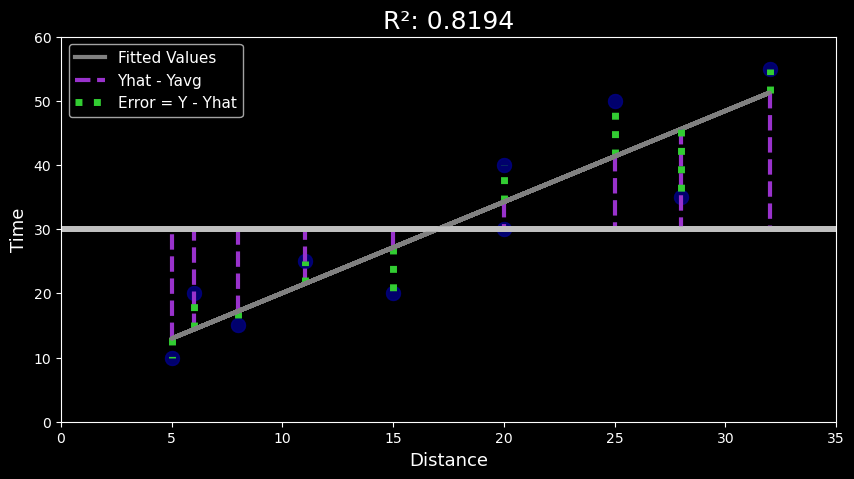

In [9]:
# Graphical view of R2 and error (residuals) concept
# Observe that residuals are the observed (actual) (Yi) values minus the expected (fitted) values (Ŷi) (in green), these are used
# to calculate the Residual Sum of Squares (SSR), at the R2 formula.
# Observe, also, the difference between the Ŷ (Yhat, expected, fitted, values) and the Yavg (in purple), which are used to 
# calculate the Explained Sum of Squares (ESS), at R2 formula.
# Observe, finally, that the difference between the Y (observed values) and the Yavg (green + purple), which are used to calculate 
# the Total Sum of Squares (TSS), at R2 formula.
# Yavg is the mean Y (observed) values, not the mean of the Ŷ (fitted) values.
plt.figure(figsize=(10,5))
y = time_distance_df['time']
yhat = time_distance_df['yhat']
x = time_distance_df['distance']
mean = np.full(x.shape[0] , y.mean(), dtype=int)
for i in range(len(x)-1):
    plt.plot(x, yhat, color='grey', linewidth=3)
    plt.plot([x[i], x[i]], [yhat[i], mean[i]], '--', color='darkorchid',
             linewidth=3)
    plt.plot([x[i], x[i]], [yhat[i], y[i]],':', color='limegreen', linewidth=5)
    plt.scatter(x, y, color='navy', s=100, alpha=0.2)
    plt.axhline(y = y.mean(), color = 'silver', linestyle = '-', linewidth=4)
    plt.title('R²: ' + str(round(ols_model.rsquared, 4)), fontsize=18)
    plt.xlabel('Distance', fontsize=13)
    plt.ylabel('Time', fontsize=13)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlim(0, 35)
    plt.ylim(0, 60)
    plt.legend(['Fitted Values', 'Yhat - Yavg', 'Error = Y - Yhat'],
               fontsize=11, loc='upper left')
plt.show()

R2 formula:

![r2.png](r2.png)

In [10]:
# calculating R2 manually - the result is the same as the one calculated by the statsmodels ols_model.summary() above
R2 = ((time_distance_df['yhat']-
       time_distance_df['time'].mean())**2).sum()/(((time_distance_df['yhat']-
                                        time_distance_df['time'].mean())**2).sum()+
                                        (time_distance_df['residual']**2).sum())

print(f"R2 = {R2}")

R2 = 0.8194256756756758


In [11]:
# another way of calculating R2 is by calculating the correlation of perason of Y and X. The R is the pearson correlation between 
# Y and X, and R2 is its square:
time_distance_df[["time","distance"]].corr()**2

,time,distance
time,1.000000,0.819426
distance,0.819426,1.000000


In [12]:
# a last way to obtain the R2 directly from the ols model is:
print(f"R2 = {ols_model.rsquared}")

R2 = 0.8194256756756757


In [13]:
# R2 (coefficient of determination) represents the percentage of Y values that is explained by the set of one or more X explicative 
# variables (in the case of SLR, only one X)... i.e., how much the explicative variable(s) contribute(s) to the value or variance 
# of the Y actual values of the model. Or in other terms, how good is our model in predicting Y values from X values. R2 varies 
# from 0 to 1, being 1 the perfect model, with 100% prediction capability, and 0 the worst model, with no prediction capability at 
# all.

# Only the fitted-value line parameters and the R2 (coefficient of determination) are not sufficient to define the ideal 
# fitted-value line, we gotta proceed hypothesis tests.

In [14]:
# If we set the Ŷ as dependent variable when defining a model, that is, if the Y (observed values) is exactly the Ŷ (expected,
# fitted, values), we'd have an R2 of 100%, 'cause the errors (residuals) would be 0, and thus the R2 formula would result in 1 -
# the Explained Sum of Squares (ESS) would be divided by itself, as the Residual Sum of Squares (SSR) would be zero.
# (see above).

perfect_model = sm.OLS.from_formula('yhat ~ distance', time_distance_df).fit()
perfect_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   yhat   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.598e+31
Date:                Sat, 28 Feb 2026   Prob (F-statistic):          1.72e-122
Time:                        02:16:08   Log-Likelihood:                 309.16
No. Observations:                  10   AIC:                            -614.3
Df Residuals:                       8   BIC:                            -613.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8784   6.83e-15   8.61e+14      0.000       5.878       5.878
distance       1.4189   3.55e-16      4e+15      0.000       1.419       1.419
==============================================================================
Omnibus:                       13.263   Durbin-Watson:                   0.046
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                1.667
Skew:                           0.000   Prob(JB):                        0.435
Kurtosis:                       1.000   Cond. No.                         41.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
print(f"R2 = {perfect_model.rsquared}")

R2 = 1.0


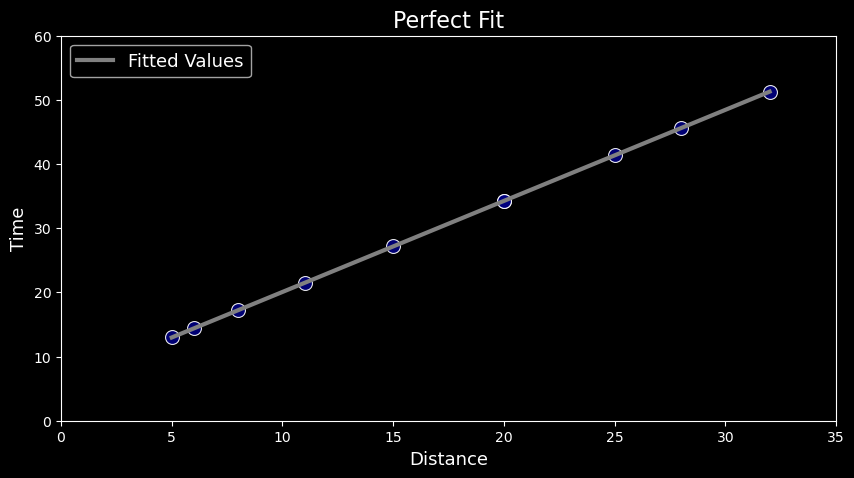

In [16]:
# Plotting scatter graph for SLR (GLM) of the perfect model above
plt.figure(figsize=(10,5))
sns.scatterplot(data=time_distance_df, x='distance', y='yhat',
                color='navy', alpha=0.9, s=100)
sns.regplot(data=time_distance_df, x='distance', y='yhat', ci=False, scatter=False,
            label='Fitted Values',
            line_kws={"color":'grey', 'linewidth': 3})
plt.title('Perfect Fit', fontsize=16)
plt.xlabel('Distance', fontsize=13)
plt.ylabel('Time', fontsize=13)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(0, 35)
plt.ylim(0, 60)
plt.legend(loc='upper left', fontsize=13)
plt.show()